## Cell-Aaverage Constant False Alarm Rate for pixel-wise ship detection

CA-CFAR model from the article: [Object Detection with Automotive Radar Sensors using CFAR Algorithms](https://www.jku.at/fileadmin/gruppen/183/Docs/Finished_Theses/Bachelor_Thesis_Katzlberger_final.pdf)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://ieeexplore.ieee.org/document/7729017/algorithms?tabFilter=dataset#algorithms)


In [1]:
import os
from os.path import join
import numpy as np 
import pandas as pd 
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor
from cfar import CA_CFAR

In [2]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

### Data Pre-processing
###### As we carry a pixel-wise classification, we will pick up only the dataset containing ships `(ship_positives)`.

Dataset presents 1596 ship containing SAR image chips from `Sentinel-1` (Extra Wide Swath) and `RADARSAT-2` sensors. 

In [4]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)
true_negative = pd.read_json(join(data_path, 'true_negatives.json'))

true_positives:  (1, 1596)


In [5]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

In [6]:
# check the polarisation mode of the dataset
plol = [ship_positives[i][0]['polarisation'] for i in range(ship_positives.size)]
pd.Series(Counter(plol))

HH    231
HV    149
VV    559
VH    657
dtype: int64

In [8]:
# print SAR imahe chip size
np.array(ship_positives[0][0]['patchgt']).shape

(101, 101)

In [20]:
# dsize = (101, 101)

# get true positive data
ship_positive_data = data_extractor(ship_positives, 'patchfu') # patchfu-101 |windowfu -21
# get the pixel based classes 
ship_positive_target = data_extractor(ship_positives, 'patchgt') # patchgt -101 |windowgt -21

In [21]:
# Resize the images
dsize = (80, 80)
ship_positive_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
target_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_target])

In [22]:
# renam the variables for the sake of ease
data = ship_positive_80
target = target_80

In [23]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 80, 80)
Target shape:	 (1596, 80, 80)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

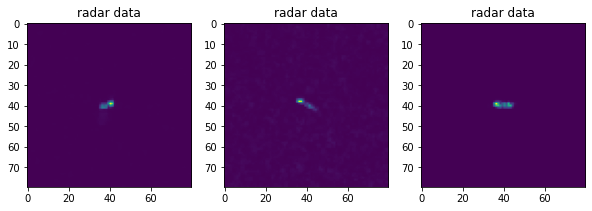

In [24]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(data[43,:,:])
axarr[2].set_title('radar data')

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

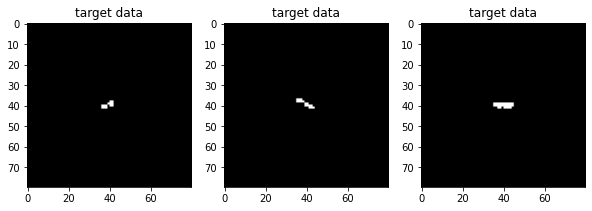

In [25]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(target[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(target[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(target[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Run CA-CFAR analysis

In [30]:
# Define parameters for CFAR
params = [10, 10, 1, 1]
P_fa = 10e-4

detedt_cfar = np.array([CA_CFAR(image, params, P_fa) for image in data])

In [31]:
# Classification report -80
# labels = np.array(['0-not ship', '1-ship'])
labels = ['0-not ship', '1-ship']

print(classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels))
# print('Confusion matrix \n', confusion_matrix(target.flatten(), detedt_cfar.flatten()))

              precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  10199206
      1-ship       0.25      0.91      0.39     15194

    accuracy                           1.00  10214400
   macro avg       0.62      0.95      0.69  10214400
weighted avg       1.00      1.00      1.00  10214400



In [13]:
# Classification report -21
# labels = np.array(['0-not ship', '1-ship'])
labels = ['0-not ship', '1-ship']

print(classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels))
print('Confusion matrix \n', confusion_matrix(target.flatten(), detedt_cfar.flatten()))

              precision    recall  f1-score   support

  0-not ship       0.99      0.99      0.99    678940
      1-ship       0.85      0.79      0.82     24896

    accuracy                           0.99    703836
   macro avg       0.92      0.89      0.91    703836
weighted avg       0.99      0.99      0.99    703836

Confusion matrix 
 [[675513   3427]
 [  5224  19672]]


In [81]:
# Classification report -101
# labels = np.array(['0-not ship', '1-ship'])
labels = ['0-not ship', '1-ship']

print(classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels))
print('Confusion matrix \n', confusion_matrix(target.flatten(), detedt_cfar.flatten()))

              precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  16255900
      1-ship       0.26      0.83      0.40     24896

    accuracy                           1.00  16280796
   macro avg       0.63      0.91      0.70  16280796
weighted avg       1.00      1.00      1.00  16280796

Confusion matrix 
 [[16198103    57797]
 [    4264    20632]]


In [72]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
# labels = np.array(['0-not ship', '1-ship'])
labels = ['0-not ship', '1-ship']

print(classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels))
print('Confusion matrix \n', confusion_matrix(target.flatten(), detedt_cfar.flatten()))

              precision    recall  f1-score   support

  0-not ship       0.99      0.99      0.99    678940
      1-ship       0.77      0.84      0.80     24896

    accuracy                           0.99    703836
   macro avg       0.88      0.91      0.90    703836
weighted avg       0.99      0.99      0.99    703836

Confusion matrix 
 [[672861   6079]
 [  4101  20795]]


In [64]:
(unique, counts) = np.unique(target, return_counts=True)
# class size
pd.Series(dict((unique, counts)))

0             1
678940    24896
dtype: int64

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

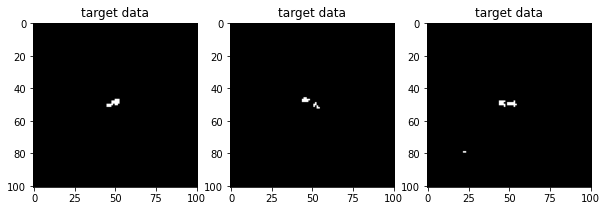

In [82]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(detedt_cfar[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(detedt_cfar[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(detedt_cfar[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images. Also one should ensure that inputs are 2d_arrays. If we pass also predicted data values of an image, the function returns bbox around the data values while vizualizing also the prediction labels on another image. However, it will still calculate the bbox parameters from label image.

<Figure size 432x288 with 0 Axes>

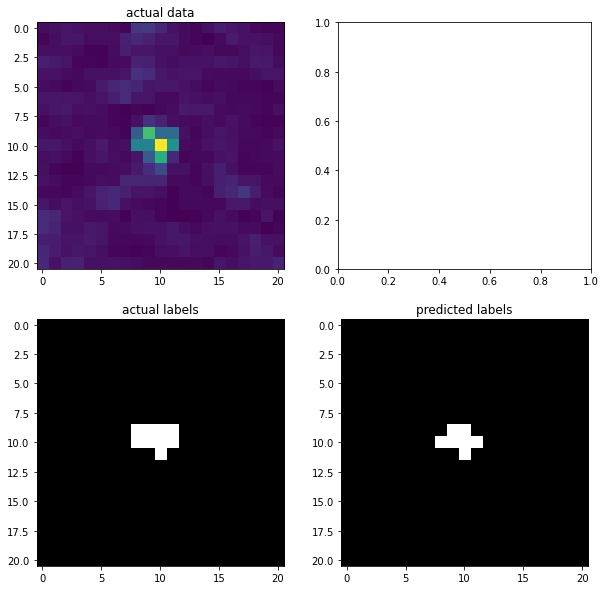

In [35]:
# define functions for vizualization 
def multiple_im_plot(no_image):
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(data[no_image])
    axarr[0,0].set_title('actual data')
    axarr[1,0].imshow(target[no_image], cmap="gray")
    axarr[1,0].set_title('actual labels')
    axarr[1,1].imshow(detedt_cfar[no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(67)   

<Figure size 432x288 with 0 Axes>

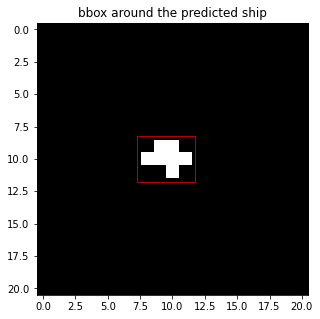

In [34]:
# vizualiza predicted ships with bbox
bbox_draw(detedt_cfar[67])